# Big Data Assignment 4

## Introduction

The data contains information about each donation made to candidates in 2016.
Hillary Clinton committee was HILLARY FOR AMERICA which has the id C00575795. Bernie
Sanders committee as called BERNIE 2016 with id C00577130. Trump’s committee was called
DONALD J. TRUMP FOR PRESIDENT, INC. with id C00580100. You need those id to find
contributions. Read the file formats to determine how to find which donations were for which
campaign and how much was donated

### Import statements and data files

In [5]:
from pyspark.sql.functions import col,sum,count
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
head_data = "./indiv_header_file.csv"
test_data = "./test_data.txt"


### Read the dataset

Clean data, select columns which are necessary for the computations and store those columns in a spark dataframe

In [6]:

def load_and_prepare_data(test_data,head_data):
        
    spark = SparkSession.builder\
            .appName("Election Campaign") \
            .getOrCreate() 
    
    # read input data
    
    election_df= spark.read.option("header","false")\
                .option("delimiter","|")\
                .csv(test_data)
    
    # read header file containing column names
    header_df = spark.read.option("header","true").option("delimiter",",")\
                .csv(head_data)
    
    election_df=header_df.union(election_df)
    
        
    # remove null values if any
    election_df = election_df.filter(election_df.TRANSACTION_AMT.isNotNull())
    
    
    # create dictionary to give names to committee ids that we are interested in
    committee_ids={"C00575795":"HILLARY FOR AMERICA","C00577130":"BERNIE 2016",
                   "C00580100":"DONALD J. TRUMP FOR PRESIDENT, INC."}
    
    
    # filter the dataset for required committee ids
    committee_3_df = election_df.select("CMTE_ID","TRANSACTION_AMT","NAME","ZIP_CODE")\
                    .where(col("TRANSACTION_AMT") > 0).where(col("CMTE_ID").isin(list(committee_ids.keys())))
    
    # assign committee names               
    committee_3_df = committee_3_df.withColumn("COMMITEE_NAME",col("CMTE_ID")).\
                    replace(to_replace=committee_ids, subset=['COMMITEE_NAME'])
    
    # display dataframe
    # committee_3_df.show()
    
    return committee_3_df


### Question 1
How many donations did each campaign have?

We need to group the data based on committee_id and the we can count the number of donations for each campaign.

In [7]:

def count_donations(committee_3_df):
    
    # count number of donations per committee
        
    count_df=committee_3_df \
            .groupBy("CMTE_ID").agg(count("TRANSACTION_AMT").alias("NUMBER_OF_DONATIONS"))
    
    count_df.show()
       

### Question 2

What was the total amount donated to each campaign?

In [8]:

def calculate_total_donation(committee_3_df):
    
    # compute the sum of total donations receeived by each committee
    
    total_donation_df = committee_3_df.groupBy("CMTE_ID")\
                    .agg(sum("TRANSACTION_AMT").alias("TOTAL_DONATION"))
    
    total_donation_df.show()
    
    return total_donation_df
     

### Question 3

What percentage of the each campaign’s donations was done by small contributors?

In [10]:


def percentage_of_small_contribution(committee_3_df,total_df):
    
    # find the total sum each person has donated to each campaign
    sum_df=committee_3_df.groupby(["CMTE_ID","NAME"]).agg(sum("TRANSACTION_AMT").alias("SUM"))\
           .select("CMTE_ID","SUM")
    
    #find small contributions
    small_sum_df=sum_df.where((col("SUM")<200)).groupby("CMTE_ID")\
                .agg(sum("SUM").alias("SMALL_CONTRIBUTIONS"))
    
    
    percent_df = small_sum_df.join(total_df, "CMTE_ID").withColumn("Percentage of Small Contributions",\
                 ((col("SMALL_CONTRIBUTIONS") / col("TOTAL_DONATION"))*100))
    
    percent_df.show()


### Question 4

Produce a histogram of the donations for each campaign

In [11]:

def histogram_of_donations(committee_3_df):
    
    hist_df =committee_3_df.select("COMMITEE_NAME","TRANSACTION_AMT").toPandas()
    #hist_df.printSchema()
    hist_df.TRANSACTION_AMT=hist_df.TRANSACTION_AMT.astype(float)
    
    hist_axes=hist_df.hist(column='TRANSACTION_AMT',by='COMMITEE_NAME',figsize=(10,20),
                           layout=(3,1),bins=50,color='g')
    
    for ax in hist_axes.flatten():
        ax.set_xlabel("Donation Value")
        ax.set_ylabel("Number of Donations")
    
   

In [12]:

def main(test_data,head_data):
    
    committee_3_df=load_and_prepare_data(test_data,head_data)
    
    count_donations(committee_3_df)
    
    total_df=calculate_total_donation(committee_3_df) 
    
    percentage_of_small_contribution(committee_3_df,total_df)
    
    histogram_of_donations(committee_3_df)
    


+---------+-------------------+
|  CMTE_ID|NUMBER_OF_DONATIONS|
+---------+-------------------+
|C00577130|                 10|
|C00575795|                461|
|C00580100|               1130|
+---------+-------------------+

+---------+--------------+
|  CMTE_ID|TOTAL_DONATION|
+---------+--------------+
|C00577130|       10608.0|
|C00575795|       58388.0|
|C00580100|      264319.0|
+---------+--------------+

+---------+-------------------+--------------+---------------------------------+
|  CMTE_ID|SMALL_CONTRIBUTIONS|TOTAL_DONATION|Percentage of Small Contributions|
+---------+-------------------+--------------+---------------------------------+
|C00575795|            10565.0|       58388.0|                18.09447146673974|
|C00580100|            26082.0|      264319.0|                9.867622077868031|
+---------+-------------------+--------------+---------------------------------+



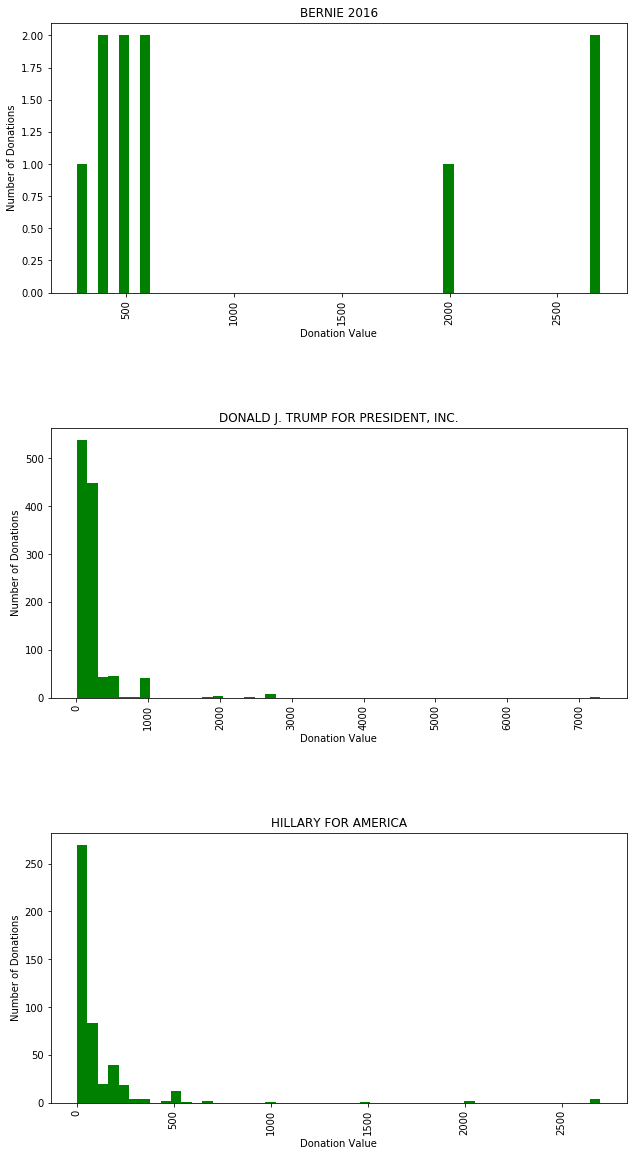

In [13]:
if __name__ == "__main__":
    
    main(test_data,head_data)